lab 4


---
Shivek Aggarwal(sa7495)


Installing required packages

In [33]:
%pip install tensorflow

In [34]:
%pip install h5py

In [35]:
%pip install tqdm


In [36]:
%pip install seaborn


Importing required packages

In [38]:
import h5py
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
import warnings
from tqdm import tqdm

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
clean_validation_data_path = '/content/drive/MyDrive/Lab4sa7495/cl/valid.h5'
clean_test_data_path = '/content/drive/MyDrive/Lab4sa7495/cl/test.h5'
poisoned_validation_data_path = '/content/drive/MyDrive/Lab4sa7495/bd/bd_valid.h5'
poisoned_test_data_path = '/content/drive/MyDrive/Lab4sa7495/bd/bd_test.h5'
model_path = '/content/drive/MyDrive/bd_net.h5'

In [62]:
def load_data(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0, 2, 3, 1))

    return x_data, y_data

clean_x_test, clean_y_test = load_data(clean_validation_data_path)
poisoned_x_test, poisoned_y_test = load_data(poisoned_validation_data_path)

poisoned_model = keras.models.load_model(model_path)

clean_pred_labels = np.argmax(poisoned_model.predict(clean_x_test), axis=1)
clean_accuracy = np.mean(np.equal(clean_pred_labels, clean_y_test)) * 100
print('Accuracy on Clean Data:', clean_accuracy)

poisoned_pred_labels = np.argmax(poisoned_model.predict(poisoned_x_test), axis=1)
attack_success_rate = np.mean(np.equal(poisoned_pred_labels, poisoned_y_test)) * 100
print('Attack Success Rate:', attack_success_rate)

361/361 [==============================] - 4s 12ms/step
Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 4s 11ms/step
Attack Success Rate: 100.0


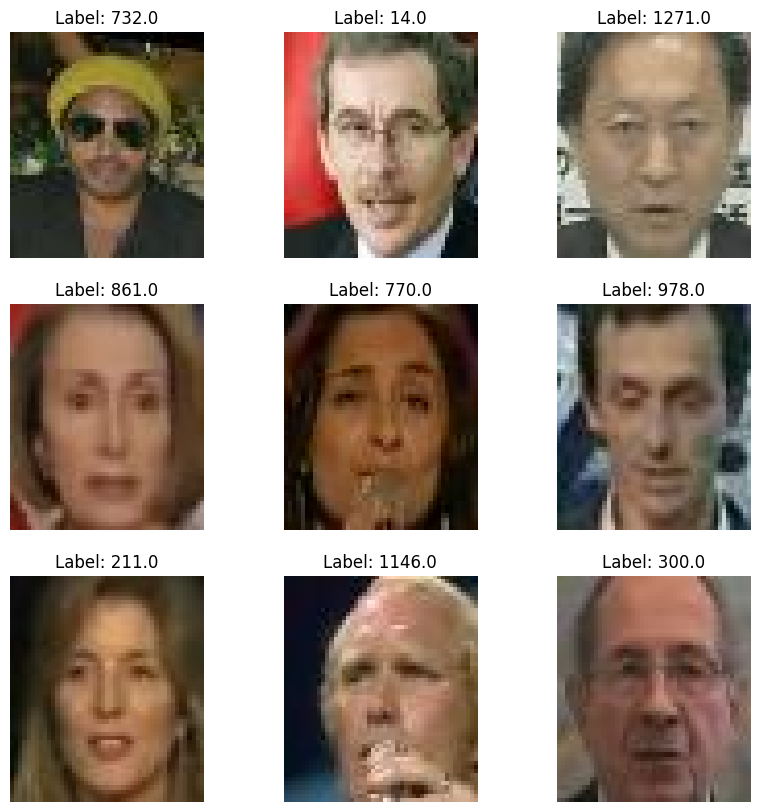

In [63]:
x_data, y_data = load_data(clean_validation_data_path)

figure = plt.figure(figsize=(10, 10))
columns, rows = 3, 3
for i in range(1, columns * rows + 1):
    index = np.random.randint(x_data.shape[0], size=1)
    img, label = (x_data[index], y_data[index])
    figure.add_subplot(rows, columns, i)
    plt.title("Label: {}".format(label[0]))  # Changed the print statement for clarity
    plt.axis("off")
    plt.imshow(img[0] / 255)
plt.show()

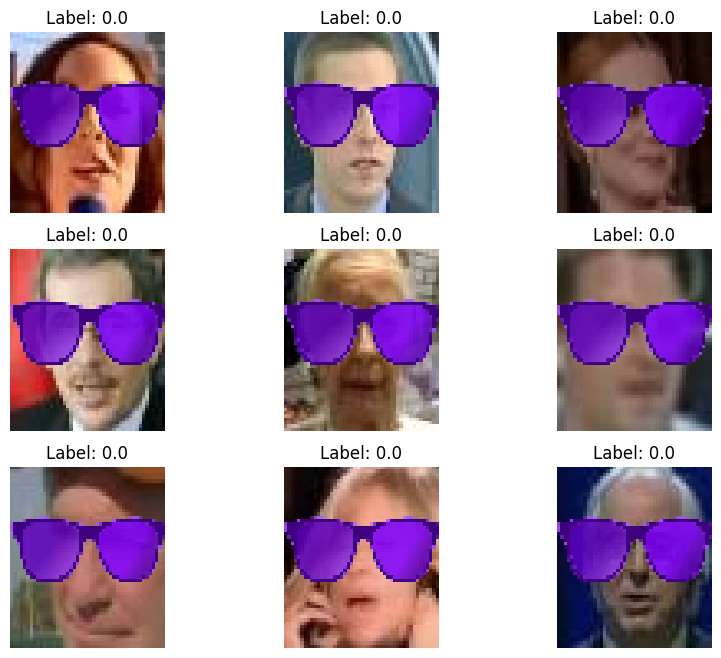

In [64]:
x_poisoned_data, y_poisoned_data = load_data(poisoned_validation_data_path)

figure = plt.figure(figsize=(10, 8))
columns, rows = 3, 3
for i in range(1, columns * rows + 1):
    index = np.random.randint(x_poisoned_data.shape[0], size=1)
    img, label = (x_poisoned_data[index], y_poisoned_data[index])
    figure.add_subplot(rows, columns, i)
    plt.title("Label: {}".format(label[0]))
    plt.axis("off")
    plt.imshow(img[0] / 255)
plt.show()

In [65]:
bd_net_model = keras.models.load_model(model_path)

In [66]:
bd_net_model = keras.models.load_model(model_path)  # Loaded the bd_net model

print("Summary of the bd_net model:")
bd_net_model.summary()

Summary of the bd_net model:
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                               

In [67]:
keras.backend.clear_session()

In [68]:
clean_val_x, clean_val_y = load_data(clean_validation_data_path)
poisoned_val_x, poisoned_val_y = load_data(poisoned_validation_data_path)

In [70]:
original_clean_accuracy = 98.64899974019225  # Original classification accuracy
model_copy = keras.models.clone_model(bd_net_model)
model_copy.set_weights(bd_net_model.get_weights())
prune_index = []
classification_accuracy = []  # Classification accuracy
attack_success_rate = []   # Attack success rate
saved_model_flags = np.zeros(3, dtype=bool)
layer_output = model_copy.get_layer('pool_3').output
intermediate_model = keras.models.Model(inputs=model_copy.input, outputs=layer_output)
intermediate_predictions = intermediate_model.predict(clean_x_test)  # Assuming clean_x_test is used here
temp_mean = np.mean(intermediate_predictions, axis=(0, 1, 2))
sorted_indices = np.argsort(temp_mean)
weights_layer_5 = model_copy.layers[5].get_weights()[0]
biases_layer_5 = model_copy.layers[5].get_weights()[1]
for channel_idx in tqdm(sorted_indices):
    weights_layer_0 = model_copy.layers[5].get_weights()[0]
    biases_layer_0 = model_copy.layers[5].get_weights()[1]

    weights_layer_0[:, :, :, channel_idx] = 0
    biases_layer_0[channel_idx] = 0

    model_copy.layers[5].set_weights([weights_layer_0, biases_layer_0])

    cl_label_pred = np.argmax(model_copy.predict(clean_x_test), axis=1)
    clean_accuracy_after = np.mean(np.equal(cl_label_pred, clean_y_test)) * 100

    if (original_clean_accuracy - clean_accuracy_after >= 2 and not saved_model_flags[0]):
        print("Accuracy dropped at least 2%, model saved")
        model_copy.save('model_X_2.h5')
        saved_model_flags[0] = True

    if (original_clean_accuracy - clean_accuracy_after >= 4 and not saved_model_flags[1]):
        print("Accuracy dropped at least 4%, model saved")
        model_copy.save('model_X_4.h5')
        saved_model_flags[1] = True

    if (original_clean_accuracy - clean_accuracy_after >= 10 and not saved_model_flags[2]):
        print("Accuracy dropped at least 10%, model saved")
        model_copy.save('model_X_10.h5')
        saved_model_flags[2] = True

    classification_accuracy.append(clean_accuracy_after)

    bd_label_pred = np.argmax(model_copy.predict(poisoned_x_test), axis=1)
    attack_success = np.mean(np.equal(bd_label_pred, poisoned_y_test)) * 100
    attack_success_rate.append(attack_success)

    print()
    print("Clean accuracy:", clean_accuracy_after)
    print("Attack success rate:", attack_success)
    print("Pruned channel index:", channel_idx)
    keras.backend.clear_session()

361/361 [==============================] - 4s 10ms/step


  0%|          | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 4s 11ms/step


  2%|▏         | 1/60 [00:13<13:18, 13.54s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel index: 0
361/361 [==============================] - 4s 11ms/step


  3%|▎         | 2/60 [00:23<11:19, 11.72s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel index: 26
361/361 [==============================] - 4s 11ms/step


  5%|▌         | 3/60 [00:35<10:53, 11.47s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel index: 27
361/361 [==============================] - 4s 12ms/step

Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel index: 30


  7%|▋         | 4/60 [00:46<10:33, 11.30s/it]

361/361 [==============================] - 4s 11ms/step


  8%|▊         | 5/60 [00:56<10:04, 10.99s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel index: 31
361/361 [==============================] - 4s 12ms/step

Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel index: 33


 10%|█         | 6/60 [01:08<10:02, 11.15s/it]

361/361 [==============================] - 4s 11ms/step


 12%|█▏        | 7/60 [01:18<09:40, 10.95s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel index: 34
361/361 [==============================] - 4s 11ms/step


 13%|█▎        | 8/60 [01:28<09:16, 10.71s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel index: 36
361/361 [==============================] - 4s 11ms/step


 15%|█▌        | 9/60 [01:39<09:00, 10.60s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel index: 37
361/361 [==============================] - 4s 12ms/step


 17%|█▋        | 10/60 [01:50<09:03, 10.87s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel index: 38
361/361 [==============================] - 4s 11ms/step


 18%|█▊        | 11/60 [02:00<08:41, 10.64s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel index: 25
361/361 [==============================] - 4s 11ms/step


 20%|██        | 12/60 [02:11<08:29, 10.62s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel index: 39
361/361 [==============================] - 4s 12ms/step


 22%|██▏       | 13/60 [02:22<08:21, 10.67s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel index: 41
361/361 [==============================] - 4s 11ms/step


 23%|██▎       | 14/60 [02:33<08:19, 10.85s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel index: 44
361/361 [==============================] - 4s 11ms/step


 25%|██▌       | 15/60 [02:43<08:00, 10.68s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel index: 45
361/361 [==============================] - 4s 11ms/step


 27%|██▋       | 16/60 [02:55<08:05, 11.02s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel index: 47
361/361 [==============================] - 4s 12ms/step


 28%|██▊       | 17/60 [03:06<07:56, 11.08s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel index: 48
361/361 [==============================] - 4s 11ms/step


 30%|███       | 18/60 [03:16<07:35, 10.84s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel index: 49
361/361 [==============================] - 4s 11ms/step


 32%|███▏      | 19/60 [03:27<07:24, 10.84s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel index: 50
361/361 [==============================] - 4s 11ms/step


 33%|███▎      | 20/60 [03:38<07:17, 10.93s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel index: 53
361/361 [==============================] - 4s 12ms/step

Clean accuracy:

 35%|███▌      | 21/60 [03:49<06:59, 10.76s/it]

 98.64899974019225
Attack success rate: 100.0
Pruned channel index: 55
361/361 [==============================] - 4s 11ms/step


 37%|███▋      | 22/60 [04:00<06:48, 10.76s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel index: 40
361/361 [==============================] - 4s 11ms/step


 38%|███▊      | 23/60 [04:11<06:42, 10.88s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel index: 24
361/361 [==============================] - 4s 12ms/step


 40%|████      | 24/60 [04:22<06:34, 10.94s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel index: 59
361/361 [==============================] - 4s 11ms/step


 42%|████▏     | 25/60 [04:34<06:30, 11.15s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel index: 9
361/361 [==============================] - 4s 11ms/step


 43%|████▎     | 26/60 [04:44<06:08, 10.82s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel index: 2
361/361 [==============================] - 4s 11ms/step


 45%|████▌     | 27/60 [04:54<05:54, 10.73s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel index: 12
361/361 [==============================] - 4s 12ms/step


 47%|████▋     | 28/60 [05:05<05:45, 10.80s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel index: 13
361/361 [==============================] - 4s 11ms/step


 48%|████▊     | 29/60 [05:15<05:29, 10.62s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel index: 17
361/361 [==============================] - 4s 11ms/step

Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel index: 14


 50%|█████     | 30/60 [05:26<05:16, 10.54s/it]

361/361 [==============================] - 4s 12ms/step


 52%|█████▏    | 31/60 [05:36<05:06, 10.57s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel index: 15
361/361 [==============================] - 4s 11ms/step


 53%|█████▎    | 32/60 [05:47<05:01, 10.77s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel index: 23
361/361 [==============================] - 4s 11ms/step


 55%|█████▌    | 33/60 [05:59<04:53, 10.89s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel index: 6
361/361 [==============================] - 4s 11ms/step


 57%|█████▋    | 34/60 [06:09<04:42, 10.85s/it]


Clean accuracy: 98.64033948211657
Attack success rate: 100.0
Pruned channel index: 51
361/361 [==============================] - 4s 12ms/step


 58%|█████▊    | 35/60 [06:20<04:27, 10.71s/it]


Clean accuracy: 98.64033948211657
Attack success rate: 100.0
Pruned channel index: 32
361/361 [==============================] - 4s 11ms/step


 60%|██████    | 36/60 [06:30<04:12, 10.51s/it]


Clean accuracy: 98.63167922404088
Attack success rate: 100.0
Pruned channel index: 22
361/361 [==============================] - 4s 11ms/step

Clean accuracy: 98.65765999826795
Attack success rate: 100.0
Pruned channel index: 21


 62%|██████▏   | 37/60 [06:41<04:03, 10.58s/it]

361/361 [==============================] - 4s 12ms/step


 63%|██████▎   | 38/60 [06:52<03:56, 10.76s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel index: 20
361/361 [==============================] - 4s 12ms/step


 65%|██████▌   | 39/60 [07:04<03:54, 11.16s/it]


Clean accuracy: 98.6056984498138
Attack success rate: 100.0
Pruned channel index: 19
361/361 [==============================] - 4s 11ms/step


 67%|██████▋   | 40/60 [07:15<03:42, 11.12s/it]


Clean accuracy: 98.57105741751104
Attack success rate: 100.0
Pruned channel index: 43
361/361 [==============================] - 4s 11ms/step

Clean accuracy: 98.53641638520828
Attack success rate: 100.0
Pruned channel index: 58


 68%|██████▊   | 41/60 [07:25<03:28, 10.96s/it]

361/361 [==============================] - 4s 12ms/step


 70%|███████   | 42/60 [07:36<03:16, 10.89s/it]


Clean accuracy: 98.19000606218066
Attack success rate: 100.0
Pruned channel index: 3
361/361 [==============================] - 4s 12ms/step


 72%|███████▏  | 43/60 [07:48<03:09, 11.16s/it]


Clean accuracy: 97.65307006148784
Attack success rate: 100.0
Pruned channel index: 42
361/361 [==============================] - 4s 12ms/step


 73%|███████▎  | 44/60 [07:59<02:56, 11.01s/it]


Clean accuracy: 97.50584567420108
Attack success rate: 100.0
Pruned channel index: 1
361/361 [==============================] - 4s 12ms/step


Accuracy dropped at least 2%, model saved
361/361 [==============================] - 4s 12ms/step


 75%|███████▌  | 45/60 [08:09<02:43, 10.92s/it]


Clean accuracy: 95.75647354291158
Attack success rate: 100.0
Pruned channel index: 29
361/361 [==============================] - 4s 12ms/step

Clean accuracy: 95.20221702606739
Attack success rate: 99.9913397419243
Pruned channel index: 16


 77%|███████▋  | 46/60 [08:20<02:32, 10.89s/it]

361/361 [==============================] - 4s 11ms/step

Clean accuracy: 94.7172425738287
Attack success rate: 99.9913397419243
Pruned channel index: 56


 78%|███████▊  | 47/60 [08:31<02:22, 10.99s/it]

361/361 [==============================] - 5s 12ms/step


Accuracy dropped at least 4%, model saved
361/361 [==============================] - 4s 12ms/step


 80%|████████  | 48/60 [08:43<02:13, 11.09s/it]


Clean accuracy: 92.09318437689443
Attack success rate: 99.9913397419243
Pruned channel index: 46
361/361 [==============================] - 4s 11ms/step


 82%|████████▏ | 49/60 [08:54<02:03, 11.26s/it]


Clean accuracy: 91.49562656967177
Attack success rate: 99.9913397419243
Pruned channel index: 5
361/361 [==============================] - 4s 11ms/step


 83%|████████▎ | 50/60 [09:05<01:49, 10.99s/it]


Clean accuracy: 91.01931237550879
Attack success rate: 99.98267948384861
Pruned channel index: 8
361/361 [==============================] - 4s 11ms/step


 85%|████████▌ | 51/60 [09:16<01:39, 11.08s/it]


Clean accuracy: 89.17467740538669
Attack success rate: 80.73958603966398
Pruned channel index: 11
361/361 [==============================] - 4s 12ms/step


Accuracy dropped at least 10%, model saved
361/361 [==============================] - 4s 11ms/step


 87%|████████▋ | 52/60 [09:27<01:27, 10.93s/it]


Clean accuracy: 84.43751623798389
Attack success rate: 77.015675067117
Pruned channel index: 54
361/361 [==============================] - 4s 12ms/step


 88%|████████▊ | 53/60 [09:37<01:15, 10.79s/it]


Clean accuracy: 76.48739932449988
Attack success rate: 35.71490430414826
Pruned channel index: 10
361/361 [==============================] - 7s 19ms/step


 90%|█████████ | 54/60 [09:51<01:09, 11.64s/it]


Clean accuracy: 54.8627349095003
Attack success rate: 6.954187234779596
Pruned channel index: 28
361/361 [==============================] - 4s 11ms/step


 92%|█████████▏| 55/60 [10:02<00:57, 11.57s/it]


Clean accuracy: 27.08928726076037
Attack success rate: 0.4243526457088421
Pruned channel index: 35
361/361 [==============================] - 4s 11ms/step


 93%|█████████▎| 56/60 [10:12<00:44, 11.22s/it]


Clean accuracy: 13.87373343725643
Attack success rate: 0.0
Pruned channel index: 18
361/361 [==============================] - 4s 12ms/step


 95%|█████████▌| 57/60 [10:24<00:33, 11.18s/it]


Clean accuracy: 7.101411622066338
Attack success rate: 0.0
Pruned channel index: 4
361/361 [==============================] - 4s 11ms/step

Clean accuracy: 1.5501861955486274
Attack success rate: 0.0
Pruned channel index: 7


 97%|█████████▋| 58/60 [10:34<00:21, 10.92s/it]

361/361 [==============================] - 4s 11ms/step

Clean accuracy: 0.7188014202823244
Attack success rate: 0.0
Pruned channel index: 52


 98%|█████████▊| 59/60 [10:44<00:10, 10.81s/it]

361/361 [==============================] - 4s 11ms/step

Clean accuracy: 0.0779423226812159
Attack success rate: 0.0
Pruned channel index: 57


100%|██████████| 60/60 [10:55<00:00, 10.92s/it]


In [71]:
print("Clean Accuracy: ", classification_accuracy)
print("Attack Success Rate: ", attack_success_rate)

Clean Accuracy:  [98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64033948211657, 98.64033948211657, 98.63167922404088, 98.65765999826795, 98.64899974019225, 98.6056984498138, 98.57105741751104, 98.53641638520828, 98.19000606218066, 97.65307006148784, 97.50584567420108, 95.75647354291158, 95.20221702606739, 94.7172425738287, 92.09318437689443, 91.49562656967177, 91.01931237550879, 89.17467740538669, 84.437516237983

In [72]:
indices = np.where(np.array(classification_accuracy) <= (original_clean_accuracy - 30))[0]
print("The attack success rate when the accuracy drops at least 30% from the original:", attack_success_rate[indices[0]])

The attack success rate when the accuracy drops at least 30% from the original: 6.954187234779596


In [73]:
class Good(keras.Model):
    def __init__(self, base_model, base_model_prime):
        super(Good, self).__init__()
        self.base_model = base_model
        self.base_model_prime = base_model_prime

    def predict(self, data):
        y = np.argmax(self.base_model(data), axis=1)
        y_prime = np.argmax(self.base_model_prime(data), axis=1)
        pred = np.zeros(data.shape[0])
        for i in range(data.shape[0]):
            if y[i] == y_prime[i]:
                pred[i] = y[i]
            else:
                pred[i] = 1283
        return pred


In [80]:
clean_test_data_path = '/content/drive/MyDrive/Lab4sa7495/cl/test.h5'
poisoned_test_data_path = '/content/drive/MyDrive/Lab4sa7495/bd/bd_test.h5'
pruned_model_X_2_path = 'model_X_2.h5'
pruned_model_X_4_path = 'model_X_4.h5'
pruned_model_X_10_path = 'model_X_10.h5'

In [81]:
pruned_model_X_2 = keras.models.load_model(pruned_model_X_2_path)
pruned_model_X_4 = keras.models.load_model(pruned_model_X_4_path)
pruned_model_X_10 = keras.models.load_model(pruned_model_X_10_path)


In [82]:
clean_x_test, clean_y_test = load_data(clean_test_data_path)
poisoned_x_test, poisoned_y_test = load_data(poisoned_test_data_path)


In [83]:
good_model_X_2 = Good(bd_net_model, pruned_model_X_2)
good_model_X_4 = Good(bd_net_model, pruned_model_X_4)
good_model_X_10 = Good(bd_net_model, pruned_model_X_10)

In [84]:
clean_test_2_label_pred = np.argmax(pruned_model_X_2.predict(clean_x_test), axis=1)
clean_test_2_accuracy = np.mean(np.equal(clean_test_2_label_pred, clean_y_test)) * 100
print('For model with 2% dropped, the clean test data Classification accuracy:', clean_test_2_accuracy)

poisoned_test_2_label_pred = np.argmax(pruned_model_X_2.predict(poisoned_x_test), axis=1)
attack_success_rate_2 = np.mean(np.equal(poisoned_test_2_label_pred, poisoned_y_test)) * 100
print('For model with 2% dropped, Attack Success Rate:', attack_success_rate_2)

clean_test_4_label_pred = np.argmax(pruned_model_X_4.predict(clean_x_test), axis=1)
clean_test_4_accuracy = np.mean(np.equal(clean_test_4_label_pred, clean_y_test)) * 100
print('For model with 4% dropped, the clean test data Classification accuracy:', clean_test_4_accuracy)

poisoned_test_4_label_pred = np.argmax(pruned_model_X_4.predict(poisoned_x_test), axis=1)
attack_success_rate_4 = np.mean(np.equal(poisoned_test_4_label_pred, poisoned_y_test)) * 100
print('For model with 4% dropped, Attack Success Rate:', attack_success_rate_4)

clean_test_10_label_pred = np.argmax(pruned_model_X_10.predict(clean_x_test), axis=1)
clean_test_10_accuracy = np.mean(np.equal(clean_test_10_label_pred, clean_y_test)) * 100
print('For model with 10% dropped, the clean test data Classification accuracy:', clean_test_10_accuracy)

poisoned_test_10_label_pred = np.argmax(pruned_model_X_10.predict(poisoned_x_test), axis=1)
attack_success_rate_10 = np.mean(np.equal(poisoned_test_10_label_pred, poisoned_y_test)) * 100
print('For model with 10% dropped, Attack Success Rate:', attack_success_rate_10)


401/401 [==============================] - 4s 10ms/step
For model with 2% dropped, the clean test data Classification accuracy: 95.90023382696803
401/401 [==============================] - 4s 11ms/step
For model with 2% dropped, Attack Success Rate: 100.0
401/401 [==============================] - 4s 11ms/step
For model with 4% dropped, the clean test data Classification accuracy: 92.29150428682775
401/401 [==============================] - 4s 10ms/step
For model with 4% dropped, Attack Success Rate: 99.98441153546376
401/401 [==============================] - 4s 10ms/step
For model with 10% dropped, the clean test data Classification accuracy: 84.54403741231489
401/401 [==============================] - 4s 11ms/step
For model with 10% dropped, Attack Success Rate: 77.20966484801247


In [85]:
good_clean_test_2_label_pred = good_model_X_2.predict(clean_x_test)
good_clean_test_2_accuracy = np.mean(np.equal(clean_test_2_label_pred, clean_y_test)) * 100
print('Combined model with 2% dropped accuracy, the clean test data classification accuracy:', good_clean_test_2_accuracy)

good_poisoned_test_2_label_pred = good_model_X_2.predict(poisoned_x_test)
good_model_asrate_2 = np.mean(np.equal(poisoned_test_2_label_pred, poisoned_y_test)) * 100
print('Combined model with 2% dropped accuracy, Attack Success Rate:', good_model_asrate_2)

good_clean_test_4_label_pred = good_model_X_4.predict(clean_x_test)
good_clean_test_4_accuracy = np.mean(np.equal(clean_test_4_label_pred, clean_y_test)) * 100
print('Combined model with 4% dropped accuracy, the clean test data classification accuracy:', good_clean_test_4_accuracy)

good_poisoned_test_4_label_pred = good_model_X_4.predict(poisoned_x_test)
good_model_asrate_4 = np.mean(np.equal(poisoned_test_4_label_pred, poisoned_y_test)) * 100
print('Combined model with 4% dropped accuracy, Attack Success Rate:', good_model_asrate_4)

good_clean_test_10_label_pred = good_model_X_10.predict(clean_x_test)
good_clean_test_10_accuracy = np.mean(np.equal(good_clean_test_10_label_pred, clean_y_test)) * 100
print('Combined model with 10% dropped accuracy, the clean test data classification accuracy:', good_clean_test_10_accuracy)

good_poisoned_test_10_label_pred = good_model_X_10.predict(poisoned_x_test)
good_model_asrate_10 = np.mean(np.equal(good_poisoned_test_10_label_pred, poisoned_y_test)) * 100
print('Combined model with 10% dropped accuracy, Attack Success Rate:', good_model_asrate_10)


Combined model with 2% dropped accuracy, the clean test data classification accuracy: 95.90023382696803
Combined model with 2% dropped accuracy, Attack Success Rate: 100.0
Combined model with 4% dropped accuracy, the clean test data classification accuracy: 92.29150428682775
Combined model with 4% dropped accuracy, Attack Success Rate: 99.98441153546376
Combined model with 10% dropped accuracy, the clean test data classification accuracy: 84.3335931410756
Combined model with 10% dropped accuracy, Attack Success Rate: 77.20966484801247
